# MC1 GBSV
## Import

In [27]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.signal import correlate
import pandas as pd
import numpy as np

## Anwendungsfall und Problemstellung

**Problemstellung:**  
Die Temperaturen in der Stadt Basel zeigen über längere Zeiträume wiederkehrende Muster, insbesondere durch saisonale Zyklen. Die Analyse dieser Muster ist entscheidend für verschiedene Anwendungsbereiche, wie Klimaforschung, Energieplanung und landwirtschaftliche Vorhersagen.
In dieser Aufgabe untersuche ich, ob und welche periodischen Muster in den Temperaturdaten von Basel über 10 Jahre bestehen. Ich verwende Auto-Korrelation, um wiederkehrende Zyklen zu identifizieren und zu analysieren.

**Ziel der Analyse:**  
1. Erkennen von periodischen Mustern (z. B. Jahreszeiten) in den Temperaturdaten.
2. Quantitative Bestimmung der Periodizität von Temperaturzyklen.
3. Ableitung von möglichen Langzeittrends oder Anomalien.
4. Demonstration der Auto-Korrelationsanalyse anhand eines ausgewählten Abschnitts der Temperaturdaten.

**Auswahl des 1D-Signals**  
Das Signal, das ich untersuche, sind tägliche Durchschnittstemperaturen aus Basel über einen Zeitraum von 10 Jahren. Dieses Signal ist eindimensional (1D), da es sich um eine Zeitreihe handelt, in der Temperaturwerte über die Zeit gemessen wurden.
Ich erwarte, dass sich saisonale Muster mit einer Periodizität von ungefähr 365 Tagen zeigen, da sich die Jahreszeiten wiederholen. Zudem könnten langfristige Trends wie Klimaerwärmung oder ungewöhnliche Wettereinflüsse sichtbar werden.

## Code zum Abrufen der Temperaturdaten von den letzten 10 Jahren in Basel (Muss nur einmal ausgeführt werden, um die Daten in ein CVS zu speichern)


In [85]:
# Dieser Code kann so von der API kopiert werden
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 47.5584,
    "longitude": 7.5733,
    "start_date": "2015-03-10",
    "end_date": "2025-03-10",
    "daily": "temperature_2m_mean"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

# Konvertiere die Zeit in das Datum ohne Uhrzeit und Zeitzone
start_date = pd.to_datetime(daily.Time(), unit="s", utc=True).normalize()  # Normalize removes the time component
end_date = pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).normalize()  # Normalize removes the time component

# Erstelle die Zeitreihe mit dem gewünschten Format
daily_data = {"date": pd.date_range(
    start=start_date,  # Das erste Datum verwenden
    end=end_date,  # Das Enddatum verwenden
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data=daily_data)

# Speichern der CSV-Datei
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)  # Erstelle den Ordner, falls er nicht existiert
csv_path = os.path.join(output_dir, "weather_data.csv")

daily_dataframe.to_csv(csv_path, index=False)


Coordinates 47.5571174621582°N 7.549342155456543°E
Elevation 283.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


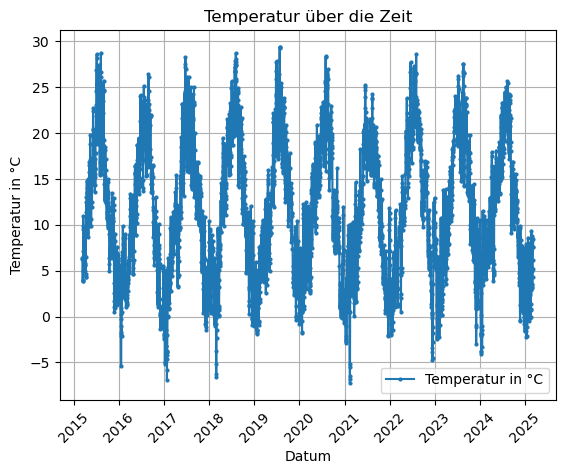

In [86]:
# CSV-Datei laden
csv_path = "C:\\Users\silas\PycharmProjects\GBSV_2025\MC1\Data\weather_data.csv"
if not os.path.exists(csv_path):
    print(f"Fehler: Datei {csv_path} nicht gefunden!")
else:
    daily_dataframe = pd.read_csv(csv_path, parse_dates=["date"])

    # Plot erstellen
    plt.plot(daily_dataframe["date"], daily_dataframe["temperature_2m_mean"], linestyle="-", marker="o", markersize=2, label="Temperatur in °C")

    # Achsentitel und Beschriftungen
    plt.xlabel("Datum")
    plt.ylabel("Temperatur in °C")
    plt.title("Temperatur über die Zeit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

# Autokorrelation- Analysieren der Resultate
Beide Autokorrelationsplots zeigen eine starke oszillierende Struktur. Im Plot über alle 10 Jahre ist zusätzlich eine abnehmende Amplitude ersichtlich, was auf eine periodische Komponente in den Temperaturdaten hinweist. Die Wahl einer hohen Lag-Zahl ist sinnvoll, da sie eine langfristige Analyse ermöglicht und dabei hilft, wiederkehrende Muster wie Jahreszeitenzyklen sichtbar zu machen, weshalb ich eher eine hohe Lag zahl empfehlen würde.
Die allmähliche Abnahme der Autokorrelation zeigt, dass der Einfluss vergangener Temperaturen mit der Zeit schwächer wird, aber regelmässige Schwankungen erhalten bleiben.

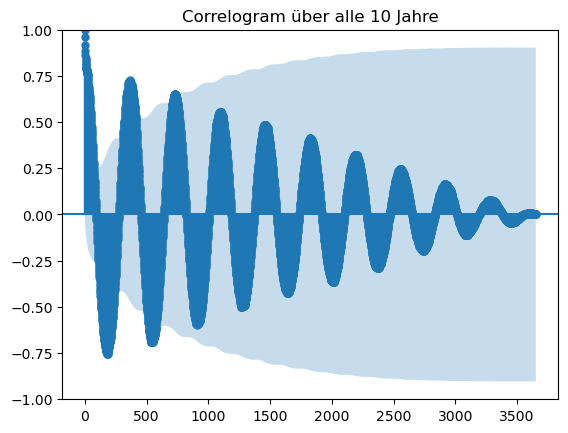

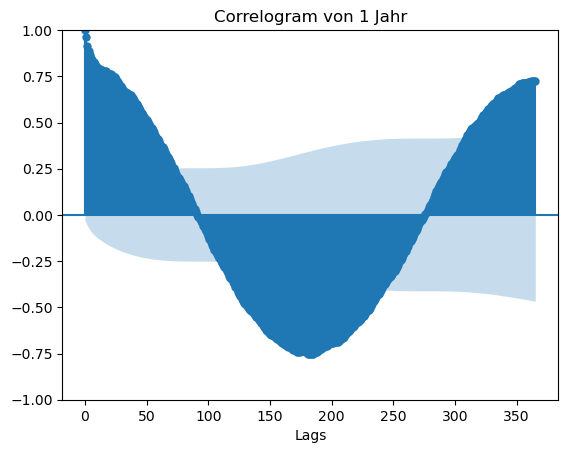

In [89]:
# Überprüfe, ob die Daten korrekt sind und NaN-Werte entfernen
temperature_data = daily_dataframe["temperature_2m_mean"].dropna()

# Bestimme die Anzahl der Lags (Verzögerungen)
lags = len(temperature_data) - 1
lags_1 = 365

# Konvertiere die Daten, falls nötig
temperature_data = temperature_data.to_numpy()

# Plot der Auto-Korrelation
sm.graphics.tsa.plot_acf(temperature_data, lags=lags, title="Correlogram über alle 10 Jahre")
sm.graphics.tsa.plot_acf(temperature_data, lags=lags_1, title="Correlogram von 1 Jahr")

# Achsentitel und Plot anzeigen
plt.xlabel("Lags")
plt.show()